<a href="https://colab.research.google.com/github/sundarjhu/Astrostatistics2025/blob/main/Lesson_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install dynesty ultranest pymc arviz pytensor

  Using cached dynesty-3.0.0-py3-none-any.whl.metadata (3.6 kB)
  Using cached ultranest-4.4.0.tar.gz (2.7 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.9/102.9 kB 2.9 MB/s eta 0:00:00
  Created wheel for ultranest: filename=ultranest-4.4.0-cp312-cp312-linux_x86_64.whl size=2325089 sha256=b114f1c1650e0b5704ad7b99e738408629807c4fc4b4dfdc83c3e0b4ab6f3d06
  Stored in directory: /root/.cache/pip/wheels/d9/d6/ac/232c612794767c59c73f1e551fd0a285bfedbb8f1202f71934
Successfully built ultranest



# Frequentist vs Bayesian Model Selection: Quadratic vs Quintic Fits

This notebook demonstrates model selection using both **frequentist** (AIC/BIC) and **Bayesian** (marginal likelihood) methods.  
We generate synthetic data from a quadratic model and compare a quadratic and a quintic polynomial fit.

The Bayesian evidence is computed robustly using **nested sampling** (`dynesty`, `UltraNest`), while **PyMC's SMC** evidence is shown with caveats about its limitations.



## 1. Generate Synthetic Data


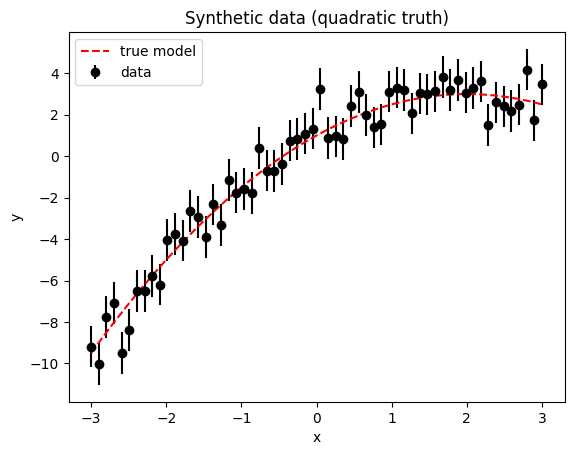

In [6]:

import numpy as np, matplotlib.pyplot as plt

rng = np.random.default_rng(42)
x = np.linspace(-3, 3, 60)
y_true = 1 + 2*x - 0.5*x**2
yerr = np.ones_like(x)
y = y_true + rng.normal(0, yerr)

plt.errorbar(x, y, yerr, fmt='o', color='k', label='data')
plt.plot(x, y_true, 'r--', label='true model')
plt.xlabel('x'); plt.ylabel('y'); plt.legend()
plt.title('Synthetic data (quadratic truth)')
plt.show()



## 2. Frequentist Fits: Quadratic and Quintic

Compute AIC and BIC to compare models under frequentist assumptions.


In [7]:

from scipy.optimize import curve_fit

def fit_poly(x, y, yerr, deg):
    p0 = np.zeros(deg+1)
    popt, pcov = curve_fit(lambda x,*p: np.polyval(p,x), x, y, sigma=yerr, p0=p0)
    return popt, pcov

def chi2(p):
    return np.sum(((y - np.polyval(p, x))/yerr)**2)

p2, c2 = fit_poly(x, y, yerr, 2)
p5, c5 = fit_poly(x, y, yerr, 5)

chi2_2, chi2_5 = chi2(p2), chi2(p5)
n = len(y)
k2, k5 = len(p2), len(p5)

AIC2, AIC5 = 2*k2 + chi2_2, 2*k5 + chi2_5
BIC2, BIC5 = k2*np.log(n) + chi2_2, k5*np.log(n) + chi2_5

print(f"AIC: quadratic={AIC2:.1f}, quintic={AIC5:.1f}")
print(f"BIC: quadratic={BIC2:.1f}, quintic={BIC5:.1f}")


AIC: quadratic=41.6, quintic=47.4
BIC: quadratic=47.9, quintic=60.0



## 3. Bayesian Evidence via Nested Sampling (dynesty)


In [8]:

import dynesty

def loglike(theta):
    model = np.polyval(theta, x)
    return -0.5*np.sum(((y - model)/yerr)**2)

def prior_transform(u):
    return 20*(u - 0.5)

logZ_dynesty = {}
for deg in [2, 5]:
    ndim = deg + 1
    sampler = dynesty.NestedSampler(loglike, prior_transform, ndim, nlive=300)
    sampler.run_nested()
    res = sampler.results
    logZ_dynesty[deg] = res.logz[-1]
    print(f"dynesty logZ (deg {deg}) = {res.logz[-1]:.2f} ± {res.logzerr[-1]:.2f}")


4526it [00:17, 260.63it/s, +300 | bound: 20 | nc: 1 | ncall: 16894 | eff(%): 29.083 | loglstar:   -inf < -17.845 <    inf | logz: -31.647 +/-  0.207 | dlogz:  0.001 >  0.309]


dynesty logZ (deg 2) = -31.65 ± 0.31


9923it [00:22, 431.68it/s, +300 | bound: 77 | nc: 1 | ncall: 34396 | eff(%): 29.983 | loglstar:   -inf < -17.857 <    inf | logz: -49.706 +/-  0.321 | dlogz:  0.001 >  0.309]

dynesty logZ (deg 5) = -49.71 ± 0.46



## 4. Bayesian Evidence via UltraNest (quiet mode)


In [9]:

import ultranest, logging, os, contextlib

def loglike_ultra(theta):
    model = np.polyval(theta, x)
    return -0.5*np.sum(((y - model)/yerr)**2)

def prior_ultra(u):
    return 20*(u - 0.5)

# Silence most output
logger = logging.getLogger("ultranest")
logger.setLevel(logging.WARNING)

logZ_ultra = {}
for deg in [2, 5]:
    names = [f"a{i}" for i in range(deg+1)]
    sampler = ultranest.ReactiveNestedSampler(names, loglike_ultra, transform=prior_ultra)
    with open(os.devnull, 'w') as f, contextlib.redirect_stderr(f):
        result = sampler.run(min_num_live_points=300, dlogz=0.1, show_status=False, viz_callback=False)
    logZ_ultra[deg] = result['logz']
    print(f"UltraNest logZ (deg {deg}) = {result['logz']:.2f} ± {result['logzerr']:.2f}")


DEBUG:ultranest:ReactiveNestedSampler: dims=3+0, resume=False, log_dir=None, backend=hdf5, vectorized=False, nbootstraps=30, ndraw=128..65536


[ultranest] To achieve the desired logz accuracy, min_num_live_points was increased to 317


INFO:ultranest:To achieve the desired logz accuracy, min_num_live_points was increased to 317


[ultranest] Sampling 317 live points from prior ...


INFO:ultranest:Sampling 317 live points from prior ...
DEBUG:ultranest:run_iter dlogz=0.1, dKL=0.5, frac_remain=0.01, Lepsilon=0.0010, min_ess=400
DEBUG:ultranest:max_iters=-1, max_ncalls=-1, max_num_improvement_loops=-1, min_num_live_points=317, cluster_num_live_points=40
DEBUG:ultranest:minimal_widths_sequence: [(np.float64(-inf), np.float64(317.0)), (np.float64(inf), np.float64(317.0))]
DEBUG:ultranest:iteration=0, ncalls=318, regioncalls=40, ndraw=40, logz=-inf, remainder_fraction=100.0000%, Lmin=-75763.01, Lmax=-218.52
DEBUG:ultranest:iteration=32, ncalls=353, regioncalls=1440, ndraw=40, logz=-49932.93, remainder_fraction=100.0000%, Lmin=-49047.31, Lmax=-218.52
DEBUG:ultranest:iteration=64, ncalls=388, regioncalls=2840, ndraw=40, logz=-40100.38, remainder_fraction=100.0000%, Lmin=-39859.65, Lmax=-218.52
DEBUG:ultranest:iteration=96, ncalls=429, regioncalls=4480, ndraw=40, logz=-33253.58, remainder_fraction=100.0000%, Lmin=-33236.35, Lmax=-218.52
DEBUG:ultranest:iteration=128, ncal

[ultranest] Explored until L=-2e+01  


INFO:ultranest:Explored until L=-2e+01  


[ultranest] Likelihood function evaluations: 10456


INFO:ultranest:Likelihood function evaluations: 10456
DEBUG:ultranest:did a run_iter pass!


[ultranest]   logZ = -31.74 +- 0.1846


INFO:ultranest:  logZ = -31.74 +- 0.1846


[ultranest] Effective samples strategy satisfied (ESS = 1484.8, need >400)


INFO:ultranest:Effective samples strategy satisfied (ESS = 1484.8, need >400)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.07 nat, need <0.50 nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.47+-0.07 nat, need <0.50 nat)
DEBUG:ultranest:  conservative estimate says at least 786 live points are needed to reach dlogz goal
DEBUG:ultranest:  number of live points vary between 316 and 316, most (5310/5311 iterations) have 315


[ultranest] Evidency uncertainty strategy wants 786 minimum live points (dlogz from 0.15 to 0.56, need <0.1)


INFO:ultranest:Evidency uncertainty strategy wants 786 minimum live points (dlogz from 0.15 to 0.56, need <0.1)


[ultranest]   logZ error budget: single: 0.20 bs:0.18 tail:0.01 total:0.18 required:<0.10


INFO:ultranest:  logZ error budget: single: 0.20 bs:0.18 tail:0.01 total:0.18 required:<0.10


[ultranest] Widening roots to 786 live points (have 317 already) ...


INFO:ultranest:Widening roots to 786 live points (have 317 already) ...


[ultranest] Sampling 469 live points from prior ...


INFO:ultranest:Sampling 469 live points from prior ...
DEBUG:ultranest:minimal_widths_sequence: [(np.float64(-inf), np.float64(786.0)), (np.float64(inf), np.float64(786.0))]
DEBUG:ultranest:iteration=1, ncalls=10926, regioncalls=409960, ndraw=40, logz=-75769.68, remainder_fraction=100.0000%, Lmin=-72813.06, Lmax=-17.82
DEBUG:ultranest:iteration=64, ncalls=10960, regioncalls=411320, ndraw=40, logz=-50565.99, remainder_fraction=100.0000%, Lmin=-50387.15, Lmax=-17.82
DEBUG:ultranest:iteration=96, ncalls=10981, regioncalls=412160, ndraw=40, logz=-45859.34, remainder_fraction=100.0000%, Lmin=-45702.92, Lmax=-17.82
DEBUG:ultranest:iteration=128, ncalls=11005, regioncalls=413120, ndraw=40, logz=-42276.17, remainder_fraction=100.0000%, Lmin=-42098.35, Lmax=-17.82
DEBUG:ultranest:iteration=160, ncalls=11025, regioncalls=413920, ndraw=40, logz=-39030.17, remainder_fraction=100.0000%, Lmin=-38992.13, Lmax=-17.82
DEBUG:ultranest:iteration=178, ncalls=11036, regioncalls=414360, ndraw=40, logz=-3683

[ultranest] Explored until L=-2e+01  


INFO:ultranest:Explored until L=-2e+01  


[ultranest] Likelihood function evaluations: 23944


INFO:ultranest:Likelihood function evaluations: 23944
DEBUG:ultranest:did a run_iter pass!


[ultranest]   logZ = -31.7 +- 0.1037


INFO:ultranest:  logZ = -31.7 +- 0.1037


[ultranest] Effective samples strategy satisfied (ESS = 3743.2, need >400)


INFO:ultranest:Effective samples strategy satisfied (ESS = 3743.2, need >400)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.03 nat, need <0.50 nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.46+-0.03 nat, need <0.50 nat)
DEBUG:ultranest:  conservative estimate says at least 1239 live points are needed to reach dlogz goal
DEBUG:ultranest:  number of live points vary between 785 and 785, most (11982/11983 iterations) have 784


[ultranest] Evidency uncertainty strategy wants 1239 minimum live points (dlogz from 0.09 to 0.21, need <0.1)


INFO:ultranest:Evidency uncertainty strategy wants 1239 minimum live points (dlogz from 0.09 to 0.21, need <0.1)


[ultranest]   logZ error budget: single: 0.13 bs:0.10 tail:0.01 total:0.10 required:<0.10


INFO:ultranest:  logZ error budget: single: 0.13 bs:0.10 tail:0.01 total:0.10 required:<0.10


[ultranest] Widening roots to 1239 live points (have 786 already) ...


INFO:ultranest:Widening roots to 1239 live points (have 786 already) ...


[ultranest] Sampling 453 live points from prior ...


INFO:ultranest:Sampling 453 live points from prior ...
DEBUG:ultranest:minimal_widths_sequence: [(np.float64(-inf), np.float64(1239.0)), (np.float64(inf), np.float64(1239.0))]
DEBUG:ultranest:iteration=0, ncalls=24398, regioncalls=936000, ndraw=40, logz=-inf, remainder_fraction=100.0000%, Lmin=-76959.65, Lmax=-17.82
DEBUG:ultranest:iteration=32, ncalls=24409, regioncalls=936440, ndraw=40, logz=-62031.08, remainder_fraction=100.0000%, Lmin=-61933.14, Lmax=-17.82
DEBUG:ultranest:iteration=96, ncalls=24432, regioncalls=937360, ndraw=40, logz=-51128.12, remainder_fraction=100.0000%, Lmin=-50753.51, Lmax=-17.82
DEBUG:ultranest:iteration=214, ncalls=24487, regioncalls=939560, ndraw=40, logz=-41132.60, remainder_fraction=100.0000%, Lmin=-41112.77, Lmax=-17.82
DEBUG:ultranest:iteration=256, ncalls=24506, regioncalls=940320, ndraw=40, logz=-39161.84, remainder_fraction=100.0000%, Lmin=-39146.83, Lmax=-17.82
DEBUG:ultranest:iteration=277, ncalls=24518, regioncalls=940800, ndraw=40, logz=-37911.5

[ultranest] Explored until L=-2e+01  


INFO:ultranest:Explored until L=-2e+01  


[ultranest] Likelihood function evaluations: 36506


INFO:ultranest:Likelihood function evaluations: 36506
DEBUG:ultranest:did a run_iter pass!


[ultranest]   logZ = -31.77 +- 0.06153


INFO:ultranest:  logZ = -31.77 +- 0.06153


[ultranest] Effective samples strategy satisfied (ESS = 5868.9, need >400)


INFO:ultranest:Effective samples strategy satisfied (ESS = 5868.9, need >400)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.04 nat, need <0.50 nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.46+-0.04 nat, need <0.50 nat)
DEBUG:ultranest:  conservative estimate says at least 1558 live points are needed to reach dlogz goal
DEBUG:ultranest:  number of live points vary between 1238 and 1238, most (17162/17163 iterations) have 1237


[ultranest] Evidency uncertainty strategy wants 1558 minimum live points (dlogz from 0.05 to 0.21, need <0.1)


INFO:ultranest:Evidency uncertainty strategy wants 1558 minimum live points (dlogz from 0.05 to 0.21, need <0.1)


[ultranest]   logZ error budget: single: 0.10 bs:0.06 tail:0.01 total:0.06 required:<0.10


INFO:ultranest:  logZ error budget: single: 0.10 bs:0.06 tail:0.01 total:0.06 required:<0.10


[ultranest] Widening roots to 1558 live points (have 1239 already) ...


INFO:ultranest:Widening roots to 1558 live points (have 1239 already) ...


[ultranest] Sampling 319 live points from prior ...


INFO:ultranest:Sampling 319 live points from prior ...
DEBUG:ultranest:minimal_widths_sequence: [(np.float64(-inf), np.float64(1558.0)), (np.float64(inf), np.float64(1558.0))]
DEBUG:ultranest:iteration=6, ncalls=36826, regioncalls=1424880, ndraw=40, logz=-71837.75, remainder_fraction=100.0000%, Lmin=-71270.60, Lmax=-17.82
DEBUG:ultranest:iteration=160, ncalls=36859, regioncalls=1426200, ndraw=40, logz=-47578.38, remainder_fraction=100.0000%, Lmin=-47500.71, Lmax=-17.82
DEBUG:ultranest:iteration=293, ncalls=36890, regioncalls=1427440, ndraw=40, logz=-40025.80, remainder_fraction=100.0000%, Lmin=-39958.98, Lmax=-17.82
DEBUG:ultranest:iteration=354, ncalls=36904, regioncalls=1428000, ndraw=40, logz=-37146.19, remainder_fraction=100.0000%, Lmin=-37118.23, Lmax=-17.82
DEBUG:ultranest:iteration=516, ncalls=36935, regioncalls=1429240, ndraw=40, logz=-31317.48, remainder_fraction=100.0000%, Lmin=-31299.68, Lmax=-17.82
DEBUG:ultranest:iteration=631, ncalls=36981, regioncalls=1431080, ndraw=40, 

[ultranest] Explored until L=-2e+01  


INFO:ultranest:Explored until L=-2e+01  


[ultranest] Likelihood function evaluations: 45324


INFO:ultranest:Likelihood function evaluations: 45324
DEBUG:ultranest:did a run_iter pass!


[ultranest]   logZ = -31.81 +- 0.06953


INFO:ultranest:  logZ = -31.81 +- 0.06953


[ultranest] Effective samples strategy satisfied (ESS = 7393.7, need >400)


INFO:ultranest:Effective samples strategy satisfied (ESS = 7393.7, need >400)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.03 nat, need <0.50 nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.46+-0.03 nat, need <0.50 nat)
DEBUG:ultranest:  conservative estimate says at least 1747 live points are needed to reach dlogz goal
DEBUG:ultranest:  number of live points vary between 1557 and 1557, most (19721/19722 iterations) have 1556
DEBUG:ultranest:  at least 1556 live points are needed to reach dlogz goal


[ultranest] Evidency uncertainty strategy wants 1556 minimum live points (dlogz from 0.06 to 0.16, need <0.1)


INFO:ultranest:Evidency uncertainty strategy wants 1556 minimum live points (dlogz from 0.06 to 0.16, need <0.1)


[ultranest]   logZ error budget: single: 0.09 bs:0.07 tail:0.01 total:0.07 required:<0.10


INFO:ultranest:  logZ error budget: single: 0.09 bs:0.07 tail:0.01 total:0.07 required:<0.10


[ultranest] done iterating.


INFO:ultranest:done iterating.
DEBUG:ultranest:ReactiveNestedSampler: dims=6+0, resume=False, log_dir=None, backend=hdf5, vectorized=False, nbootstraps=30, ndraw=128..65536


UltraNest logZ (deg 2) = -31.81 ± 0.14
[ultranest] To achieve the desired logz accuracy, min_num_live_points was increased to 317


INFO:ultranest:To achieve the desired logz accuracy, min_num_live_points was increased to 317


[ultranest] Sampling 317 live points from prior ...


INFO:ultranest:Sampling 317 live points from prior ...
DEBUG:ultranest:run_iter dlogz=0.1, dKL=0.5, frac_remain=0.01, Lepsilon=0.0010, min_ess=400
DEBUG:ultranest:max_iters=-1, max_ncalls=-1, max_num_improvement_loops=-1, min_num_live_points=317, cluster_num_live_points=40
DEBUG:ultranest:minimal_widths_sequence: [(np.float64(-inf), np.float64(317.0)), (np.float64(inf), np.float64(317.0))]
DEBUG:ultranest:iteration=0, ncalls=318, regioncalls=40, ndraw=40, logz=-inf, remainder_fraction=100.0000%, Lmin=-24001194.01, Lmax=-11794.59
DEBUG:ultranest:iteration=32, ncalls=352, regioncalls=1400, ndraw=40, logz=-17662574.33, remainder_fraction=100.0000%, Lmin=-17492086.60, Lmax=-11794.59
DEBUG:ultranest:iteration=64, ncalls=385, regioncalls=2720, ndraw=40, logz=-14156682.95, remainder_fraction=100.0000%, Lmin=-14114664.00, Lmax=-11794.59
DEBUG:ultranest:iteration=96, ncalls=428, regioncalls=4440, ndraw=40, logz=-11908286.74, remainder_fraction=100.0000%, Lmin=-11879534.33, Lmax=-11794.59
DEBUG:

[ultranest] Explored until L=-2e+01  


INFO:ultranest:Explored until L=-2e+01  


[ultranest] Likelihood function evaluations: 33621


INFO:ultranest:Likelihood function evaluations: 33621
DEBUG:ultranest:did a run_iter pass!


[ultranest]   logZ = -49.69 +- 0.209


INFO:ultranest:  logZ = -49.69 +- 0.209


[ultranest] Effective samples strategy satisfied (ESS = 2075.7, need >400)


INFO:ultranest:Effective samples strategy satisfied (ESS = 2075.7, need >400)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.06 nat, need <0.50 nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.47+-0.06 nat, need <0.50 nat)
DEBUG:ultranest:  conservative estimate says at least 1088 live points are needed to reach dlogz goal
DEBUG:ultranest:  number of live points vary between 316 and 316, most (10401/10402 iterations) have 315


[ultranest] Evidency uncertainty strategy wants 1088 minimum live points (dlogz from 0.18 to 0.44, need <0.1)


INFO:ultranest:Evidency uncertainty strategy wants 1088 minimum live points (dlogz from 0.18 to 0.44, need <0.1)


[ultranest]   logZ error budget: single: 0.30 bs:0.21 tail:0.01 total:0.21 required:<0.10


INFO:ultranest:  logZ error budget: single: 0.30 bs:0.21 tail:0.01 total:0.21 required:<0.10


[ultranest] Widening roots to 1088 live points (have 317 already) ...


INFO:ultranest:Widening roots to 1088 live points (have 317 already) ...


[ultranest] Sampling 771 live points from prior ...


INFO:ultranest:Sampling 771 live points from prior ...
DEBUG:ultranest:minimal_widths_sequence: [(np.float64(-inf), np.float64(1088.0)), (np.float64(inf), np.float64(1088.0))]
DEBUG:ultranest:iteration=0, ncalls=34393, regioncalls=1348880, ndraw=40, logz=-inf, remainder_fraction=100.0000%, Lmin=-24269505.28, Lmax=-17.75
DEBUG:ultranest:iteration=64, ncalls=34434, regioncalls=1350520, ndraw=40, logz=-18860187.74, remainder_fraction=100.0000%, Lmin=-18808918.48, Lmax=-17.75
DEBUG:ultranest:iteration=128, ncalls=34478, regioncalls=1352280, ndraw=40, logz=-15757977.66, remainder_fraction=100.0000%, Lmin=-15745744.94, Lmax=-17.75
DEBUG:ultranest:iteration=160, ncalls=34503, regioncalls=1353280, ndraw=40, logz=-14722434.46, remainder_fraction=100.0000%, Lmin=-14678913.76, Lmax=-17.75
DEBUG:ultranest:iteration=192, ncalls=34530, regioncalls=1354360, ndraw=40, logz=-13787100.23, remainder_fraction=100.0000%, Lmin=-13772703.15, Lmax=-17.75
DEBUG:ultranest:iteration=243, ncalls=34570, regioncall

[ultranest] Explored until L=-2e+01  


INFO:ultranest:Explored until L=-2e+01  


[ultranest] Likelihood function evaluations: 95019


INFO:ultranest:Likelihood function evaluations: 95019
DEBUG:ultranest:did a run_iter pass!


[ultranest]   logZ = -49.64 +- 0.1121


INFO:ultranest:  logZ = -49.64 +- 0.1121


[ultranest] Effective samples strategy satisfied (ESS = 7058.5, need >400)


INFO:ultranest:Effective samples strategy satisfied (ESS = 7058.5, need >400)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
DEBUG:ultranest:  conservative estimate says at least 2013 live points are needed to reach dlogz goal
DEBUG:ultranest:  number of live points vary between 1087 and 1087, most (31598/31599 iterations) have 1086


[ultranest] Evidency uncertainty strategy wants 2013 minimum live points (dlogz from 0.09 to 0.32, need <0.1)


INFO:ultranest:Evidency uncertainty strategy wants 2013 minimum live points (dlogz from 0.09 to 0.32, need <0.1)


[ultranest]   logZ error budget: single: 0.16 bs:0.11 tail:0.01 total:0.11 required:<0.10


INFO:ultranest:  logZ error budget: single: 0.16 bs:0.11 tail:0.01 total:0.11 required:<0.10


[ultranest] Widening roots to 2013 live points (have 1088 already) ...


INFO:ultranest:Widening roots to 2013 live points (have 1088 already) ...


[ultranest] Sampling 925 live points from prior ...


INFO:ultranest:Sampling 925 live points from prior ...
DEBUG:ultranest:minimal_widths_sequence: [(np.float64(-inf), np.float64(2013.0)), (np.float64(inf), np.float64(2013.0))]
DEBUG:ultranest:iteration=5, ncalls=95945, regioncalls=3793160, ndraw=40, logz=-23736518.76, remainder_fraction=100.0000%, Lmin=-23499122.37, Lmax=-17.71
DEBUG:ultranest:iteration=32, ncalls=95957, regioncalls=3793640, ndraw=40, logz=-21655867.90, remainder_fraction=100.0000%, Lmin=-21418729.03, Lmax=-17.71
DEBUG:ultranest:iteration=98, ncalls=95989, regioncalls=3794920, ndraw=40, logz=-19109842.55, remainder_fraction=100.0000%, Lmin=-19042703.58, Lmax=-17.71
DEBUG:ultranest:iteration=160, ncalls=96015, regioncalls=3795960, ndraw=40, logz=-17281633.48, remainder_fraction=100.0000%, Lmin=-17277576.42, Lmax=-17.71
DEBUG:ultranest:iteration=192, ncalls=96031, regioncalls=3796600, ndraw=40, logz=-16506357.79, remainder_fraction=100.0000%, Lmin=-16453849.26, Lmax=-17.71
DEBUG:ultranest:iteration=224, ncalls=96052, reg

[ultranest] Explored until L=-2e+01  


INFO:ultranest:Explored until L=-2e+01  


[ultranest] Likelihood function evaluations: 161976


INFO:ultranest:Likelihood function evaluations: 161976
DEBUG:ultranest:did a run_iter pass!


[ultranest]   logZ = -49.69 +- 0.08544


INFO:ultranest:  logZ = -49.69 +- 0.08544


[ultranest] Effective samples strategy satisfied (ESS = 12973.1, need >400)


INFO:ultranest:Effective samples strategy satisfied (ESS = 12973.1, need >400)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.03 nat, need <0.50 nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.46+-0.03 nat, need <0.50 nat)
DEBUG:ultranest:  conservative estimate says at least 2741 live points are needed to reach dlogz goal
DEBUG:ultranest:  number of live points vary between 2012 and 2012, most (67315/67316 iterations) have 2011


[ultranest] Evidency uncertainty strategy wants 2741 minimum live points (dlogz from 0.06 to 0.22, need <0.1)


INFO:ultranest:Evidency uncertainty strategy wants 2741 minimum live points (dlogz from 0.06 to 0.22, need <0.1)


[ultranest]   logZ error budget: single: 0.12 bs:0.09 tail:0.01 total:0.09 required:<0.10


INFO:ultranest:  logZ error budget: single: 0.12 bs:0.09 tail:0.01 total:0.09 required:<0.10


[ultranest] Widening roots to 2741 live points (have 2013 already) ...


INFO:ultranest:Widening roots to 2741 live points (have 2013 already) ...


[ultranest] Sampling 728 live points from prior ...


INFO:ultranest:Sampling 728 live points from prior ...
DEBUG:ultranest:minimal_widths_sequence: [(np.float64(-inf), np.float64(2741.0)), (np.float64(inf), np.float64(2741.0))]
DEBUG:ultranest:iteration=0, ncalls=162705, regioncalls=6456760, ndraw=40, logz=-inf, remainder_fraction=100.0000%, Lmin=-25051484.56, Lmax=-17.71
DEBUG:ultranest:iteration=67, ncalls=162723, regioncalls=6457480, ndraw=40, logz=-20686223.15, remainder_fraction=100.0000%, Lmin=-20673780.32, Lmax=-17.71
DEBUG:ultranest:iteration=123, ncalls=162738, regioncalls=6458080, ndraw=40, logz=-19383155.72, remainder_fraction=100.0000%, Lmin=-19325710.39, Lmax=-17.71
DEBUG:ultranest:iteration=180, ncalls=162757, regioncalls=6458840, ndraw=40, logz=-18012891.57, remainder_fraction=100.0000%, Lmin=-18010756.54, Lmax=-17.71
DEBUG:ultranest:iteration=234, ncalls=162775, regioncalls=6459560, ndraw=40, logz=-17080262.99, remainder_fraction=100.0000%, Lmin=-17049355.49, Lmax=-17.71
DEBUG:ultranest:iteration=300, ncalls=162797, regi

[ultranest] Explored until L=-2e+01  


INFO:ultranest:Explored until L=-2e+01  


[ultranest] Likelihood function evaluations: 214054


INFO:ultranest:Likelihood function evaluations: 214054
DEBUG:ultranest:did a run_iter pass!


[ultranest]   logZ = -49.76 +- 0.04799


INFO:ultranest:  logZ = -49.76 +- 0.04799


[ultranest] Effective samples strategy satisfied (ESS = 17576.3, need >400)


INFO:ultranest:Effective samples strategy satisfied (ESS = 17576.3, need >400)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.03 nat, need <0.50 nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.46+-0.03 nat, need <0.50 nat)
DEBUG:ultranest:  conservative estimate says at least 3200 live points are needed to reach dlogz goal
DEBUG:ultranest:  number of live points vary between 2740 and 2740, most (95458/95459 iterations) have 2739


[ultranest] Evidency uncertainty strategy wants 3200 minimum live points (dlogz from 0.04 to 0.10, need <0.1)


INFO:ultranest:Evidency uncertainty strategy wants 3200 minimum live points (dlogz from 0.04 to 0.10, need <0.1)


[ultranest]   logZ error budget: single: 0.10 bs:0.05 tail:0.01 total:0.05 required:<0.10


INFO:ultranest:  logZ error budget: single: 0.10 bs:0.05 tail:0.01 total:0.05 required:<0.10


[ultranest] Widening roots to 3200 live points (have 2741 already) ...


INFO:ultranest:Widening roots to 3200 live points (have 2741 already) ...


[ultranest] Sampling 459 live points from prior ...


INFO:ultranest:Sampling 459 live points from prior ...
DEBUG:ultranest:minimal_widths_sequence: [(np.float64(-inf), np.float64(3200.0)), (np.float64(inf), np.float64(3200.0))]
DEBUG:ultranest:iteration=6, ncalls=214514, regioncalls=8534400, ndraw=40, logz=-23963179.92, remainder_fraction=100.0000%, Lmin=-23878387.11, Lmax=-17.71
DEBUG:ultranest:iteration=51, ncalls=214520, regioncalls=8534640, ndraw=40, logz=-21512942.49, remainder_fraction=100.0000%, Lmin=-21422501.73, Lmax=-17.71
DEBUG:ultranest:iteration=101, ncalls=214525, regioncalls=8534840, ndraw=40, logz=-20134595.63, remainder_fraction=100.0000%, Lmin=-20128772.15, Lmax=-17.71
DEBUG:ultranest:iteration=142, ncalls=214533, regioncalls=8535160, ndraw=40, logz=-19381161.83, remainder_fraction=100.0000%, Lmin=-19331114.45, Lmax=-17.71
DEBUG:ultranest:iteration=174, ncalls=214539, regioncalls=8535400, ndraw=40, logz=-18639313.49, remainder_fraction=100.0000%, Lmin=-18626440.70, Lmax=-17.71
DEBUG:ultranest:iteration=231, ncalls=2145

[ultranest] Explored until L=-2e+01  


INFO:ultranest:Explored until L=-2e+01  


[ultranest] Likelihood function evaluations: 246042


INFO:ultranest:Likelihood function evaluations: 246042
DEBUG:ultranest:did a run_iter pass!


[ultranest]   logZ = -49.72 +- 0.05768


INFO:ultranest:  logZ = -49.72 +- 0.05768


[ultranest] Effective samples strategy satisfied (ESS = 20512.8, need >400)


INFO:ultranest:Effective samples strategy satisfied (ESS = 20512.8, need >400)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.02 nat, need <0.50 nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.46+-0.02 nat, need <0.50 nat)
DEBUG:ultranest:  conservative estimate says at least 3455 live points are needed to reach dlogz goal
DEBUG:ultranest:  number of live points vary between 3199 and 3199, most (96193/96194 iterations) have 3198
DEBUG:ultranest:  at least 3198 live points are needed to reach dlogz goal


[ultranest] Evidency uncertainty strategy wants 3198 minimum live points (dlogz from 0.04 to 0.18, need <0.1)


INFO:ultranest:Evidency uncertainty strategy wants 3198 minimum live points (dlogz from 0.04 to 0.18, need <0.1)


[ultranest]   logZ error budget: single: 0.10 bs:0.06 tail:0.01 total:0.06 required:<0.10


INFO:ultranest:  logZ error budget: single: 0.10 bs:0.06 tail:0.01 total:0.06 required:<0.10


[ultranest] done iterating.


INFO:ultranest:done iterating.


UltraNest logZ (deg 5) = -49.71 ± 0.18



## 5. PyMC (SMC) Evidence — with caveats

PyMC's Sequential Monte Carlo sampler estimates the log-evidence (`log_marginal_likelihood`),  
but in recent versions this value may be unavailable or `NaN`.

We check it explicitly and report if it's missing.  
For robust Bayesian model comparison, **dynesty** and **UltraNest** should be preferred.


In [10]:

import pymc as pm, pytensor.tensor as pt, arviz as az

def pymc_model(deg):
    with pm.Model() as model:
        coeff = pm.Normal("coeff", 0, 10, shape=deg + 1)
        mu = pt.zeros_like(x)
        for i, c in enumerate(coeff):
            mu += c * x ** (deg - i)
        sigma = pm.HalfNormal("sigma", 1)
        pm.Normal("y", mu=mu, sigma=sigma, observed=y)
    return model

logZ_pymc = {}
for deg in [2, 5]:
    model = pymc_model(deg)
    with model:
        idata = pm.sample_smc(draws=2000, chains=1, progressbar=False, return_inferencedata=True)
        logZ = idata.sample_stats.attrs.get("log_marginal_likelihood", np.nan)
        if np.isnan(logZ):
            print(f"Warning: PyMC logZ for degree {deg} is NaN (may not be computed).\n"
                  "This is expected in PyMC >= 5.12 when the sampler does not record evidence.")
        logZ_pymc[deg] = logZ
        print(f"PyMC logZ (deg {deg}) = {logZ:.2f}")


This is expected in PyMC >= 5.12 when the sampler does not record evidence.
PyMC logZ (deg 2) = nan
This is expected in PyMC >= 5.12 when the sampler does not record evidence.
PyMC logZ (deg 5) = nan



## 6. Compare Evidences and Interpret


In [11]:

logZs = {'dynesty': logZ_dynesty, 'ultranest': logZ_ultra, 'pymc': logZ_pymc}
for method, vals in logZs.items():
    if len(vals) == 2:
        lnB = vals[2] - vals[5]
        print(f"{method:8s}: lnB = {lnB:.2f}")


dynesty : lnB = 18.06
ultranest: lnB = 17.91
pymc    : lnB = nan



## 7. Discussion
- Dynesty and UltraNest produce consistent evidence values.
- PyMC's evidence field is often NaN due to current API limitations.
- Nested sampling is the robust and recommended way to compute Bayesian evidence.

| Δln Z | Strength of Evidence |
|:------:|:--------------------|
| < 1 | Inconclusive |
| 1–2.5 | Weak |
| 2.5–5 | Moderate |
| > 5 | Strong |

In this dataset (quadratic truth), all samplers should favor the quadratic model.
